# Import Libraries

In [16]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy.optimize as sciOp
from scipy.optimize import curve_fit
from scipy.optimize import golden
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
import warnings
from tqdm import trange
from matplotlib import cm

# Initialize Parameters

In [17]:
#### Grid Parameters
TE_array = np.arange(8, 513, 8) #ms units

percent_err = 0.1   #Add and subtract this percent from the null point estimated value
err_steps = 21      #This is the number of steps between the two ranges of the null point estimated values

#### Model parameters
c1 = 0.4
c2 = 0.6
T21 = 45 #75
T22 = 60 #80
T11 = 600 #150
T12 = 1200 #450

true_params = np.array([T11, T12, c1, c2, T21, T22])

param_list = [r'$T_{11}$', r'$T_{12}$', r'$c_{1}$', r'$c_{2}$', r'$T_{21}$', r'$T_{22}$']

#### Nullpoint Values
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#Bound used during NLLS to constrain the upper bound on T2 values
T1_bound = 1500
T2_bound = 300

#### Process parameters
SNR_fixed = 100        #This is the default SNR value
num_iters = 1          #This is how many noisey repitions are used for each TI value
num_starts = 2         #For each iteration, this many starts are used to determine the best parameters - the best answer here for the monoexponential is 2

round_params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_params)
pTitleList = ', '.join(x for x in param_list)

details = (f"\nNull Point SNR = {SNR_fixed} \nNum fminbnd Repetitions = {num_iters} :: Num Multistarts (RSS) = {num_starts}" + 
           f"\n{param_list} = {pList}")

print(f'TI1* null point {TI1star}')
print(f'TI2* null point {TI2star}')

TI1* null point 415.88830833596717
TI2* null point 831.7766166719343


# Initialize Functions

### General Functions

In [18]:
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_5p_ravel(T_dat, T11, c1, d2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def S_moX_3p(T_dat, c, T1, T2):
    TE, TI = T_dat
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

def add_noise(data, SNR):
    sigma = np.max(np.abs(data))/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    return data + noise

def get_func_bounds(function):
    f_name = function.__name__
    if f_name == "S_biX_4p":
        lower_bound = (-1,-1,0,0)
        upper_bound = (1,1,300,300)
    elif f_name == "S_moX_2p":
        lower_bound = (-1,0)
        upper_bound = (1,300)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name == "S_biX_4p":
        params = ("d1","d2","T21","T22")
    elif f_name == "S_moX_2p":
        params = ("d","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(lb, ub, func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        f_name = func.__name__
        if f_name.find("moX") > -1:
            p0 = [0,80]
        elif f_name.find("biX") > -1:
            p0 = [0,0,60,80]
        else:
            p0 = true_params
            
    return p0

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore,axis=0)
    biMat = np.mean(paramStore - true_params ,axis=0)
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, biMat, varMat

### Process Functions

In [19]:
def check_param_order(popt, func):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    
    f_name = func.__name__
    num = 0
    if 'off' in f_name:
        num = -1

    if (popt[-2+num] > popt[-1+num]): #We want by convention to make sure that T21 is <= T22
        for i in range(popt.shape[0]//2):
            p_hold = popt[2*i]
            popt[2*i] = popt[2*i+1]
            popt[2*i+1] = p_hold
    return popt

def estimate_NLLS(func, tdata, data, init_p, lb, ub):

    popt, pcov = curve_fit(func, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)
    popt = check_param_order(popt, func)
        
    return popt

def generate_noised_sigs(TI, tdata, SNR = SNR_fixed, params = true_params, iterations = num_iters):
    
    noised_ensemble = np.zeros((iterations,np.size(tdata)))
    for iter in range(iterations):
        # np.random.seed(seed_val+iter)
        true_sig = S_biX_6p(tdata, TI, *params)
        noised_sig = add_noise(true_sig, SNR)
        noised_ensemble[iter,:] = noised_sig
    return noised_ensemble

def multistart_estimate_NLLS(func, tdata, noisey_sig, lb, ub, starts = num_starts):
    best_RSS = np.inf
    best_params = [] 
    for start in range(starts):
        init_p = set_p0(lb, ub, func) #This should almost always be a random initial starting location
        hold_popt = estimate_NLLS(func, tdata, noisey_sig, init_p, lb, ub)
        recreated_curve = func(tdata, *hold_popt)
        recreated_curves_RSS = np.sum((noisey_sig - recreated_curve)**2)

        if recreated_curves_RSS < best_RSS:
            best_RSS = recreated_curves_RSS
            best_params = hold_popt
        
    return best_params, best_RSS

def logical_estimation(TI1st, TI2st, data_np1, data_np2):
    guess_T11 = TI1st/np.log(2)
    guess_T12 = TI2st/np.log(2)

    lb, ub = get_func_bounds(S_moX_2p)

    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np1, lb, ub)
    guess_d2 = best_params[0]
    guess_T22 = best_params[1]

    guess_c2 = guess_d2 / (1 - 2*np.exp(-TI1st/guess_T12))

    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np2, lb, ub)
    guess_d1 = best_params[0]
    guess_T21 = best_params[1]

    guess_c1 = guess_d1 / (1 - 2*np.exp(-TI2st/guess_T11))

    guess_params = [guess_T11, guess_T12, guess_c1, guess_c2, guess_T21, guess_T22]

    return guess_params

def logical_estimation_half(TI_np, data_np):
    guess_T11 = TI_np/np.log(2)

    lb, ub = get_func_bounds(S_moX_2p)

    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np, lb, ub)
    guess_d2 = best_params[0]
    guess_T22 = best_params[1]

    guess_params = [guess_T11, guess_d2, guess_T22]

    return guess_params

### Plotting Functions

In [20]:
def get_hist_index(param_label):
    if param_label[-1] == '2':
        row = 1
    else:
        row = 0

    if param_label[:-1] == "T1":
        col = 0
        if param_label[-1] == '2':
            row = 0
        else:
            row = 1
    elif param_label[:-1] == "c" or param_label[:-1] == "d":
        col = 1
    else:
        col = 2

    return row, col

def parameter_halfEst(delta_array, param_metric, labels, add_title, deets = "", xlab = 'Delta Value', ylab = 'Metric'):
    fig, ax = plt.subplots(1, 3, figsize=(12,4), tight_layout=True)
    fig.suptitle(add_title + deets)

    for ii in range(param_metric.shape[-1]):

        row, col = get_hist_index(labels[ii])
        #Construct a nice figure of each of the two 
        ax[col].plot(delta_array*100, param_metric[:,ii])
        ax[col].axvline(x = 0, color='r', linestyle = '-', alpha=0.2)
        ax[col].set_xlabel(xlab)
        ax[col].set_ylabel(ylab + f" of {labels[ii]}")
        ax[col].set_title(f"{labels[ii]} Estimate")
    plt.show()
    return

def parameter_fullEst(delta_array, param_metric, labels, add_title, deets = "", xlab = 'Delta Value on TI2*', ylab = 'Delta Value on TI2*', pos = True):
    fig, ax = plt.subplots(2, 3, figsize=(12,7), tight_layout=True)
    fig.suptitle(add_title + deets)

    for ii in range(param_metric.shape[-1]):

        row, col = get_hist_index(labels[ii])
        #Construct a nice figure of each of the two 
        imc = ax[row, col].imshow(param_metric[:,:,ii], cmap = 'RdBu', vmin = -1*np.max(np.abs(param_metric[:,:,ii])), vmax = np.max(np.abs(param_metric[:,:,ii])))
        ax[row, col].set_xlabel(xlab)
        ax[row, col].set_ylabel(ylab)
        ax[row, col].set_xticks(np.arange(len(delta_array)))
        ax[row, col].set_yticks(np.arange(len(delta_array)))
        ax[row, col].set_xticklabels(delta_array)
        ax[row, col].set_yticklabels(delta_array)
        original_labels = [np.round(label,2) for label in delta_array]
        labels_of_interest = [np.round(delta_array[i],2) for i in np.arange(0,delta_array.shape[0],5)]
        new_labels = [label if label in labels_of_interest else "" for label in original_labels]
        ax[row, col].set_xticklabels(new_labels, rotation=-45)
        ax[row, col].set_yticklabels(new_labels)
        ax[row, col].set_title(f"{labels[ii]} Estimate")
        plt.colorbar(imc, ax=ax[row, col], fraction=0.046, pad=0.04)
    plt.show()
    return


# Null Point Error Propagation

In [21]:
delta_NN_range_rel = np.linspace(-1*percent_err, percent_err, 21)

delta_NN_1p = np.zeros((delta_NN_range_rel.shape[0], 3))
delta_SNR_1p = np.zeros((delta_NN_range_rel.shape[0], 3))

for iDelt in trange(delta_NN_range_rel.shape[0]):
    delta_change = delta_NN_range_rel[iDelt]*TI1star
    T1_star_est = TI1star+delta_change
    data_np = S_biX_6p(TE_array, T1_star_est, T11, T12, c1, c2, T21, T22)
    delta_NN_1p[iDelt,:] = logical_estimation_half(T1_star_est, data_np)

    data_np = add_noise(data_np, SNR_fixed)
    delta_SNR_1p[iDelt,:] = logical_estimation_half(T1_star_est, data_np)

100%|██████████| 21/21 [00:00<00:00, 46.25it/s]


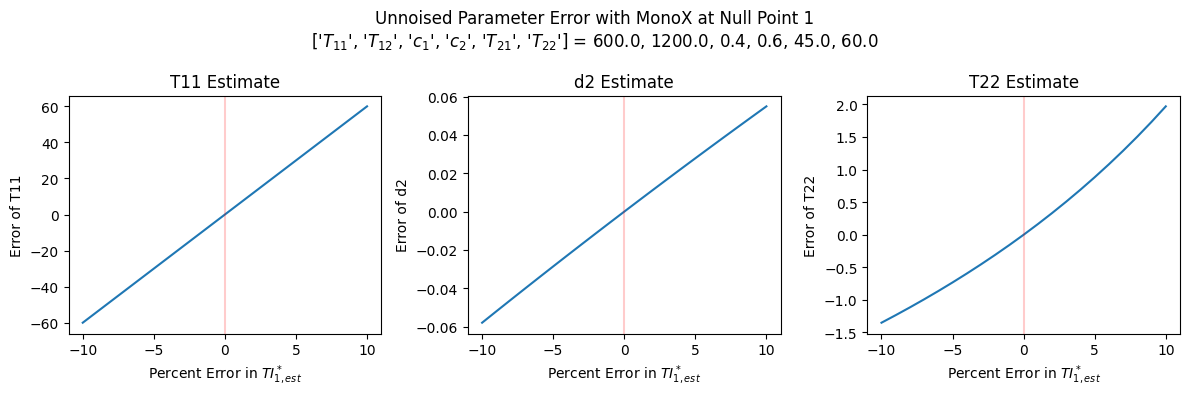

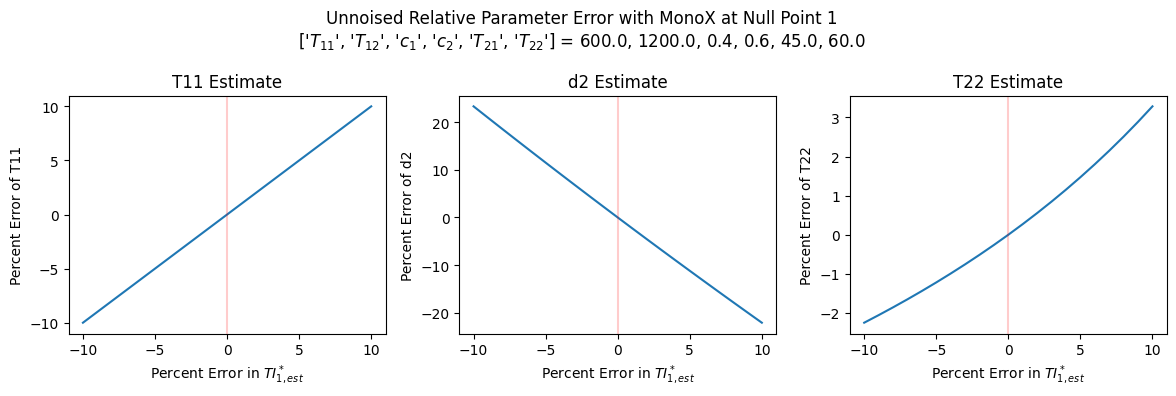

In [22]:
d2_null_point_TI1star = c2*(1-2*np.exp(-TI1star/T12))

np_params = [T11, d2_null_point_TI1star, T22]

TI1star_error = delta_NN_1p - np_params
TI1star_error_rel = TI1star_error/np_params*100

np_label_1 = r'$TI^*_{1,est}$'

details = (f"\n{param_list} = {pList}")

parameter_halfEst(delta_NN_range_rel, TI1star_error, ['T11','d2','T22'], "Unnoised Parameter Error with MonoX at Null Point 1", deets = details, xlab = f'Percent Error in {np_label_1}', ylab = 'Error')

parameter_halfEst(delta_NN_range_rel, TI1star_error_rel, ['T11','d2','T22'], "Unnoised Relative Parameter Error with MonoX at Null Point 1", deets = details, xlab = f'Percent Error in {np_label_1}', ylab = 'Percent Error')


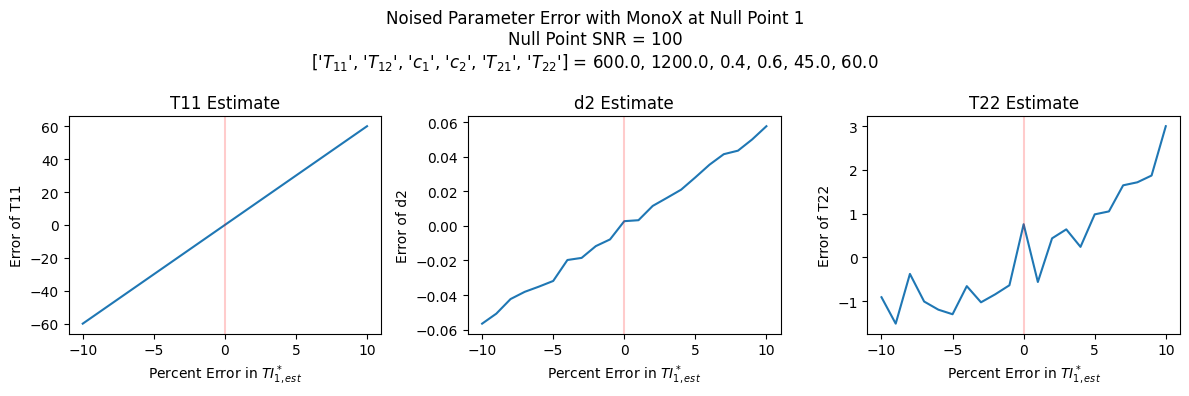

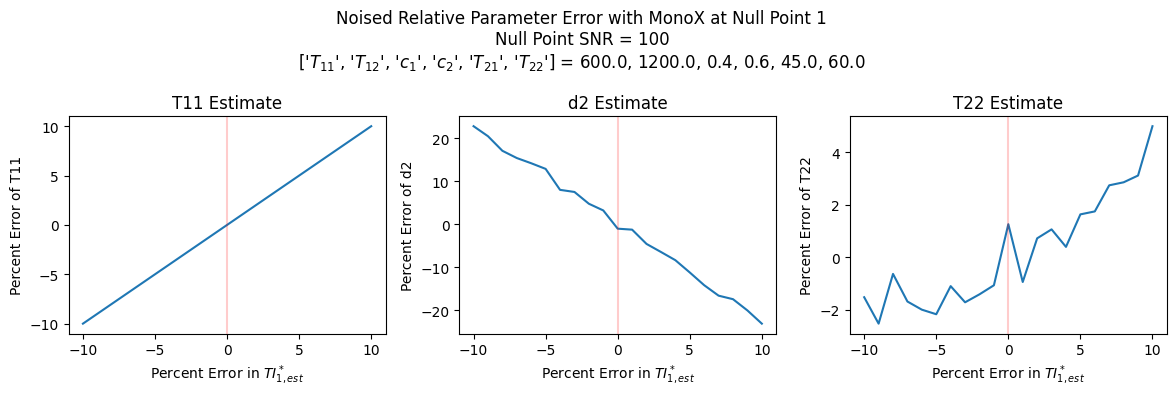

In [23]:
TI1star_error_SNR = delta_SNR_1p - np_params
TI1star_error_rel_SNR = TI1star_error_SNR/np_params*100

np_label_1 = r'$TI^*_{1,est}$'

details = (f"\nNull Point SNR = {SNR_fixed}" + 
           f"\n{param_list} = {pList}")

parameter_halfEst(delta_NN_range_rel, TI1star_error_SNR, ['T11','d2','T22'], "Noised Parameter Error with MonoX at Null Point 1", deets = details, xlab = f'Percent Error in {np_label_1}', ylab = 'Error')

parameter_halfEst(delta_NN_range_rel, TI1star_error_rel_SNR, ['T11','d2','T22'], "Noised Relative Parameter Error with MonoX at Null Point 1", deets = details, xlab = f'Percent Error in {np_label_1}', ylab = 'Percent Error')


In [24]:
delta_NN_range_rel = np.linspace(-1*percent_err, percent_err, 21)

delta_NN_1p = np.zeros((delta_NN_range_rel.shape[0], 3))
delta_SNR_1p = np.zeros((delta_NN_range_rel.shape[0], 3))

for iDelt in trange(delta_NN_range_rel.shape[0]):
    delta_change = delta_NN_range_rel[iDelt]*TI2star
    T2_star_est = TI2star+delta_change
    data_np = S_biX_6p(TE_array, T2_star_est, T11, T12, c1, c2, T21, T22)
    delta_NN_1p[iDelt,:] = logical_estimation_half(T2_star_est, data_np)

    data_np = add_noise(data_np, SNR_fixed)
    delta_SNR_1p[iDelt,:] = logical_estimation_half(T2_star_est, data_np)

100%|██████████| 21/21 [00:00<00:00, 85.20it/s]


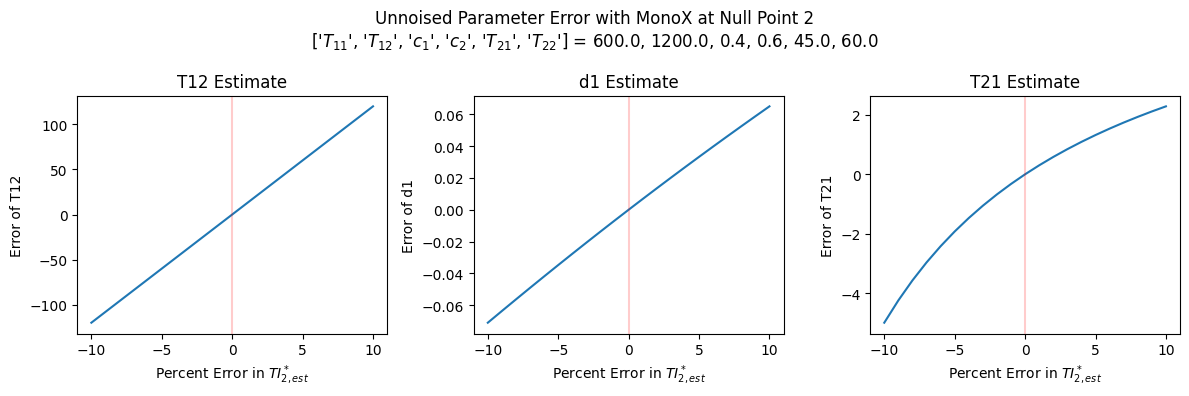

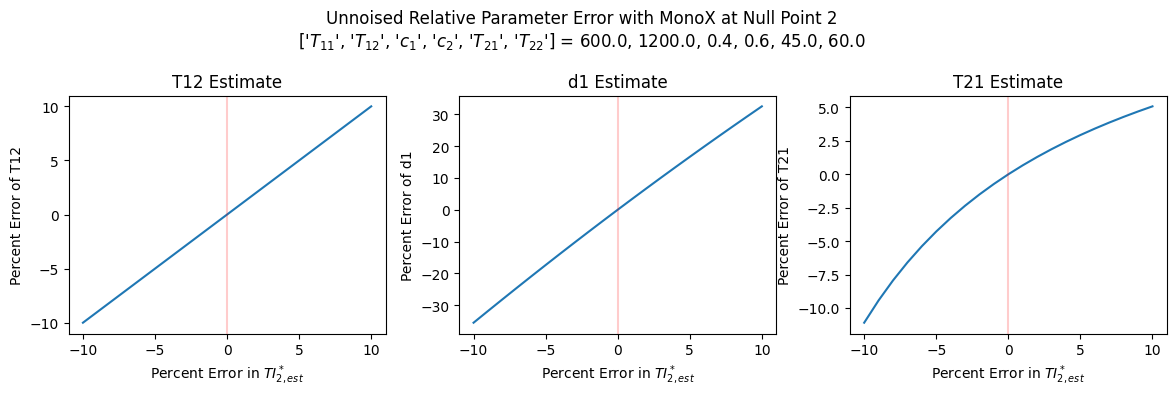

In [25]:
d1_null_point_TI2star = c1*(1-2*np.exp(-TI2star/T11))

np_params = [T12, d1_null_point_TI2star, T21]

TI2star_error = delta_NN_1p - np_params
TI2star_error_rel = TI2star_error/np_params*100

np_label_2 = r'$TI^*_{2,est}$'

details = (f"\n{param_list} = {pList}")

parameter_halfEst(delta_NN_range_rel, TI2star_error, ['T12','d1','T21'], "Unnoised Parameter Error with MonoX at Null Point 2", deets = details, xlab = f'Percent Error in {np_label_2}', ylab = 'Error')

parameter_halfEst(delta_NN_range_rel, TI2star_error_rel, ['T12','d1','T21'], "Unnoised Relative Parameter Error with MonoX at Null Point 2", deets = details, xlab = f'Percent Error in {np_label_2}', ylab = 'Percent Error')


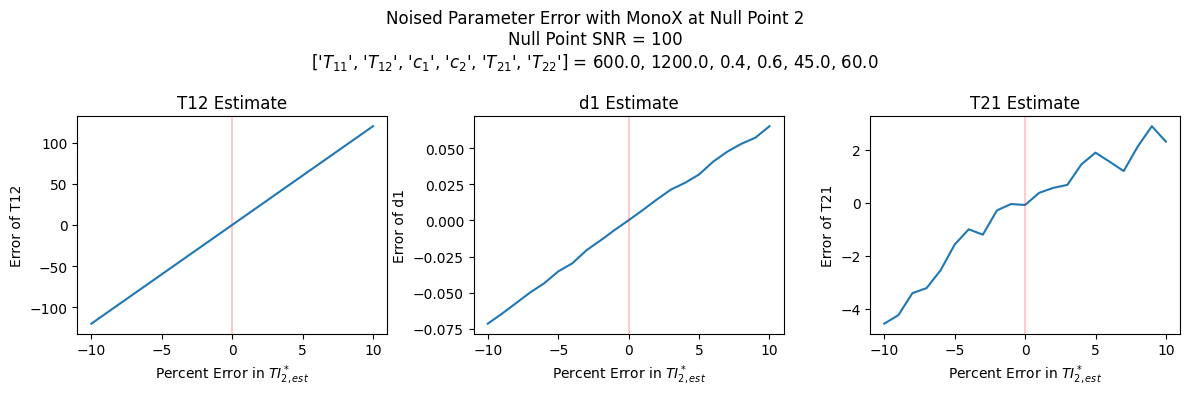

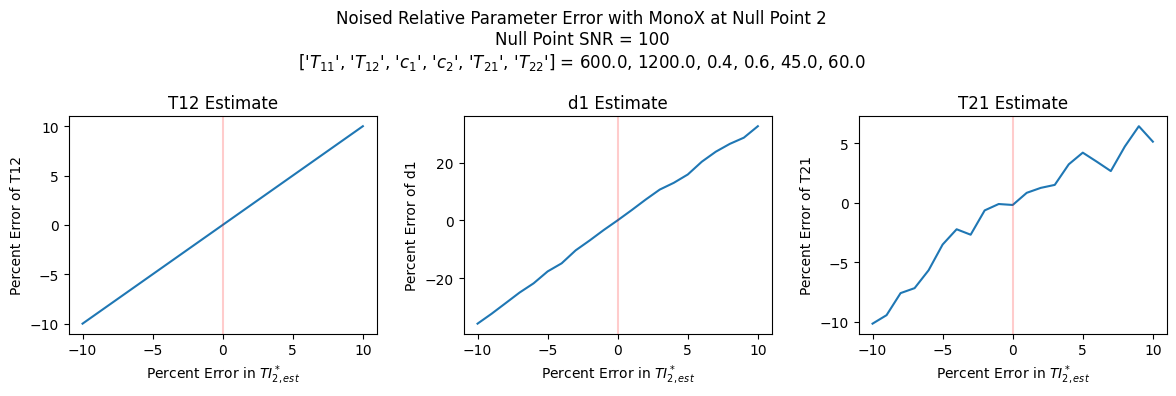

In [26]:
TI2star_error_SNR = delta_SNR_1p - np_params
TI2star_error_rel_SNR = TI2star_error_SNR/np_params*100

np_label_2 = r'$TI^*_{2,est}$'

details = (f"\nNull Point SNR = {SNR_fixed}" + 
           f"\n{param_list} = {pList}")

parameter_halfEst(delta_NN_range_rel, TI2star_error_SNR, ['T12','d1','T21'], "Noised Parameter Error with MonoX at Null Point 2", deets = details, xlab = f'Percent Error in {np_label_2}', ylab = 'Error')

parameter_halfEst(delta_NN_range_rel, TI2star_error_rel_SNR, ['T12','d1','T21'], "Noised Relative Parameter Error with MonoX at Null Point 2", deets = details, xlab = f'Percent Error in {np_label_2}', ylab = 'Percent Error')


# Heat Map

In [27]:
allParam_range_rel = np.linspace(-1*percent_err, percent_err, 21)

delta_NN_2p = np.zeros((allParam_range_rel.shape[0], allParam_range_rel.shape[0], 6))
delta_SNR_2p = np.zeros((allParam_range_rel.shape[0], allParam_range_rel.shape[0], 6))

for iDelt in trange(allParam_range_rel.shape[0]):       #Loops through TI1star related values
    for jDelt in range(allParam_range_rel.shape[0]):   #Loops through TI2star related values
        idelta_change = allParam_range_rel[iDelt]*TI1star
        jdelta_change = allParam_range_rel[jDelt]*TI2star
        T1_star_est = TI1star + idelta_change
        T2_star_est = TI2star + jdelta_change
        data_np_1 = S_biX_6p(TE_array, T1_star_est, T11, T12, c1, c2, T21, T22)
        data_np_2 = S_biX_6p(TE_array, T2_star_est, T11, T12, c1, c2, T21, T22)
        delta_NN_2p[iDelt,jDelt,:] = logical_estimation(T1_star_est, T2_star_est, data_np_1, data_np_2)

        data_np_1 = add_noise(data_np_1, SNR_fixed)
        data_np_2 = add_noise(data_np_2, SNR_fixed)
        delta_SNR_2p[iDelt,jDelt,:] = logical_estimation(T1_star_est, T2_star_est, data_np_1, data_np_2)

100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


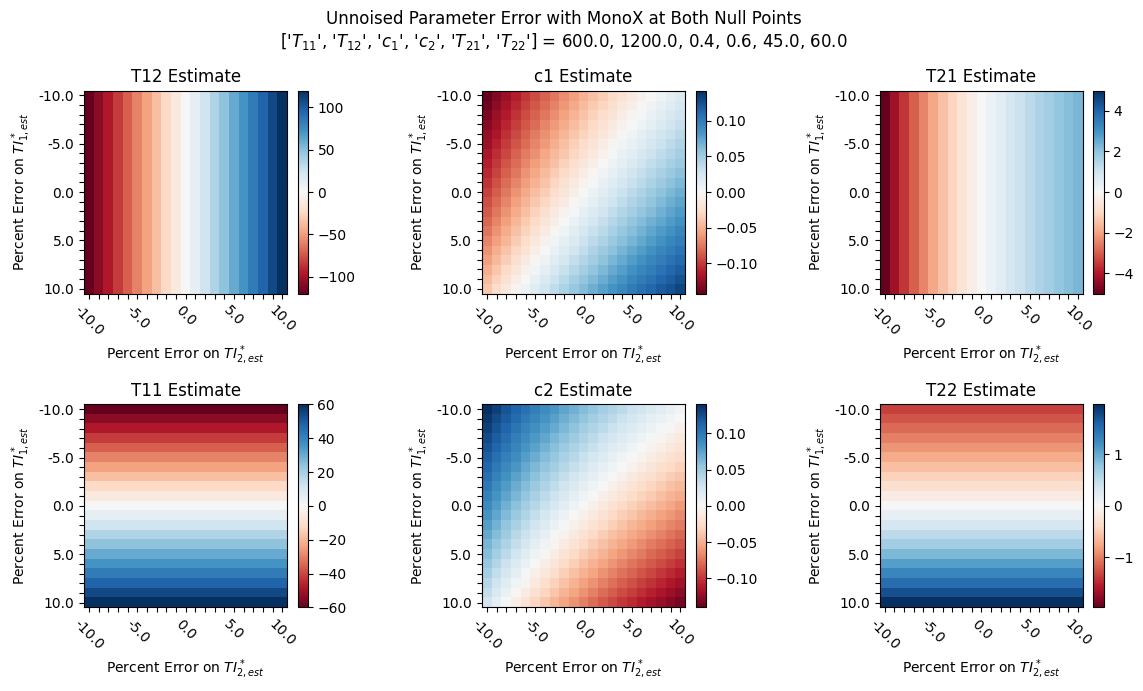

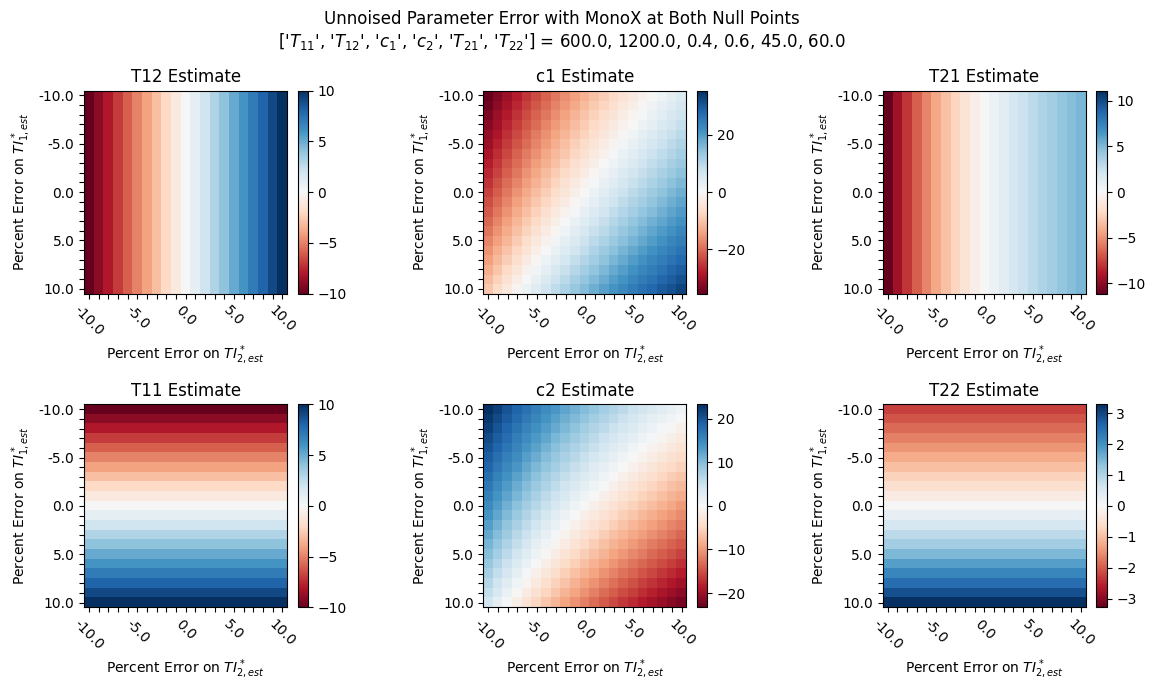

In [28]:
allParam_error = delta_NN_2p - true_params
allParam_error_rel = allParam_error/true_params*100

details = (f"\n{param_list} = {pList}")

parameter_fullEst(allParam_range_rel*100, allParam_error, ['T11','T12','c1','c2','T21','T22'], "Unnoised Parameter Error with MonoX at Both Null Points", deets = details, xlab = f'Percent Error on {np_label_2}', ylab = f'Percent Error on {np_label_1}', pos = False)

parameter_fullEst(allParam_range_rel*100, allParam_error_rel, ['T11','T12','c1','c2','T21','T22'], "Unnoised Parameter Error with MonoX at Both Null Points", deets = details, xlab = f'Percent Error on {np_label_2}', ylab = f'Percent Error on {np_label_1}', pos = False)


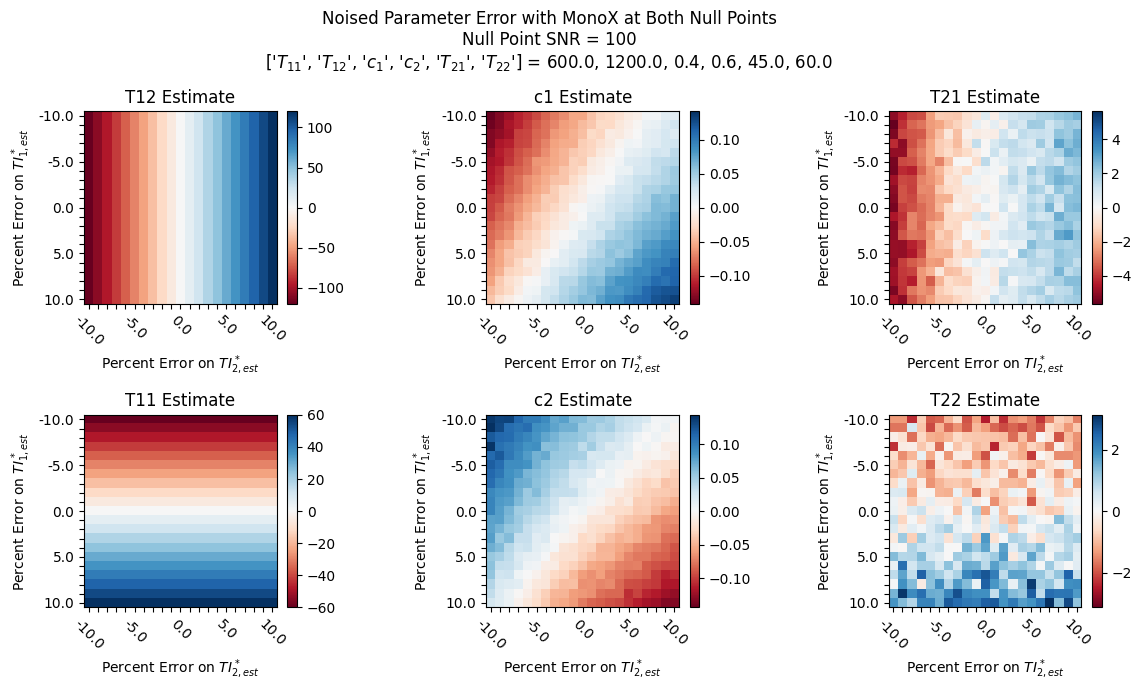

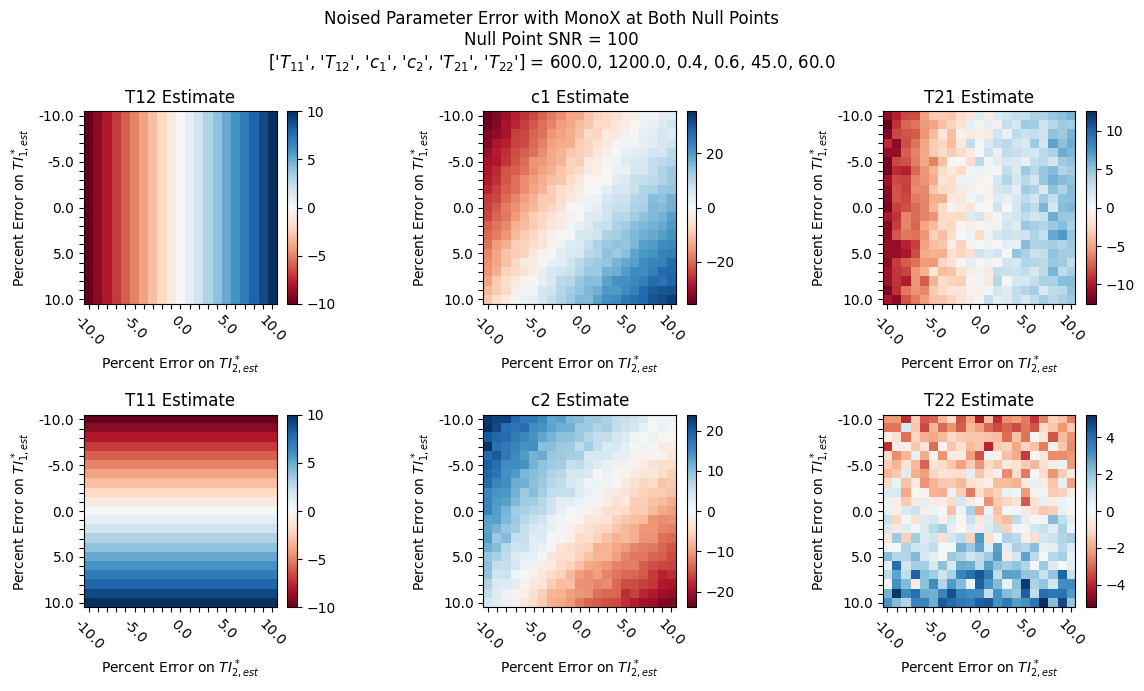

In [29]:
allParam_error_SNR = delta_SNR_2p - true_params
allParam_error_rel_SNR = allParam_error_SNR/true_params*100

details = (f"\nNull Point SNR = {SNR_fixed}" + 
           f"\n{param_list} = {pList}")

parameter_fullEst(allParam_range_rel*100, allParam_error_SNR, ['T11','T12','c1','c2','T21','T22'], "Noised Parameter Error with MonoX at Both Null Points", deets = details, xlab = f'Percent Error on {np_label_2}', ylab = f'Percent Error on {np_label_1}', pos = False)

parameter_fullEst(allParam_range_rel*100, allParam_error_rel_SNR, ['T11','T12','c1','c2','T21','T22'], "Noised Parameter Error with MonoX at Both Null Points", deets = details, xlab = f'Percent Error on {np_label_2}', ylab = f'Percent Error on {np_label_1}', pos = False)


# Optimal Figure

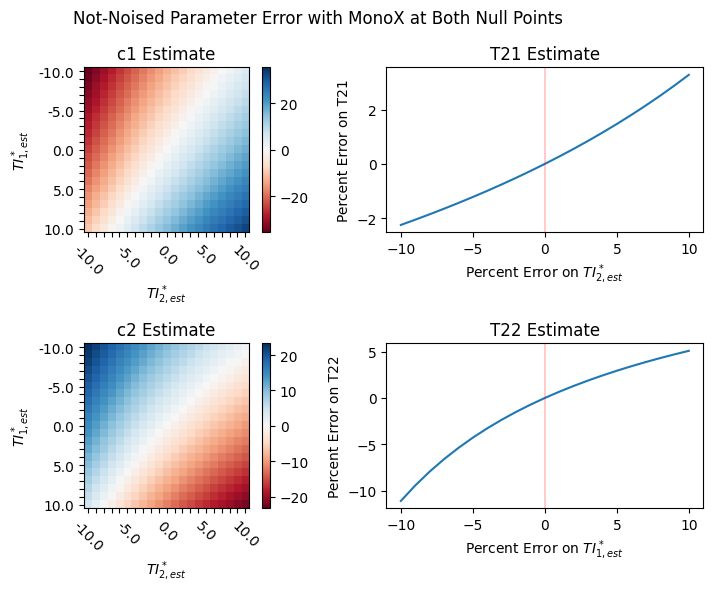

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(8,6), tight_layout=True)
fig.suptitle(f"Not-Noised Parameter Error with MonoX at Both Null Points")

delta_array = allParam_range_rel*100
param_metric = allParam_error_rel

labels = ['T11','T12','c1','c2','T21','T22']

ii = 2
row = 0
col = 0
#Construct a nice figure of each of the two 
imc = ax[row, col].imshow(param_metric[:,:,ii], cmap = 'RdBu', vmin = -1*np.max(np.abs(param_metric[:,:,ii])), vmax = np.max(np.abs(param_metric[:,:,ii])))
ax[row, col].set_xlabel(np_label_2)
ax[row, col].set_ylabel(np_label_1)
ax[row, col].set_xticks(np.arange(len(delta_array)))
ax[row, col].set_yticks(np.arange(len(delta_array)))
ax[row, col].set_xticklabels(delta_array)
ax[row, col].set_yticklabels(delta_array)
original_labels = [np.round(label,2) for label in delta_array]
labels_of_interest = [np.round(delta_array[i],2) for i in np.arange(0,delta_array.shape[0],5)]
new_labels = [label if label in labels_of_interest else "" for label in original_labels]
ax[row, col].set_xticklabels(new_labels, rotation=-45)
ax[row, col].set_yticklabels(new_labels)
ax[row, col].set_title(f"c1 Estimate")
plt.colorbar(imc, ax=ax[row, col], fraction=0.046, pad=0.04)

ii = 3
row = 1
col = 0
#Construct a nice figure of each of the two 
imc = ax[row, col].imshow(param_metric[:,:,ii], cmap = 'RdBu', vmin = -1*np.max(np.abs(param_metric[:,:,ii])), vmax = np.max(np.abs(param_metric[:,:,ii])))
ax[row, col].set_xlabel(np_label_2)
ax[row, col].set_ylabel(np_label_1)
ax[row, col].set_xticks(np.arange(len(delta_array)))
ax[row, col].set_yticks(np.arange(len(delta_array)))
ax[row, col].set_xticklabels(delta_array)
ax[row, col].set_yticklabels(delta_array)
original_labels = [np.round(label,2) for label in delta_array]
labels_of_interest = [np.round(delta_array[i],2) for i in np.arange(0,delta_array.shape[0],5)]
new_labels = [label if label in labels_of_interest else "" for label in original_labels]
ax[row, col].set_xticklabels(new_labels, rotation=-45)
ax[row, col].set_yticklabels(new_labels)
ax[row, col].set_title(f"c2 Estimate")
plt.colorbar(imc, ax=ax[row, col], fraction=0.046, pad=0.04)

ii = 2
param_metric = TI1star_error_rel
row = 0
col = 1
#Construct a nice figure of each of the two 
ax[row, col].plot(delta_array, param_metric[:,ii])
ax[row, col].axvline(x = 0, color='r', linestyle = '-', alpha=0.2)
ax[row, col].set_xlabel(f"Percent Error on {np_label_2}")
ax[row, col].set_ylabel(f"Percent Error on T21")
ax[row, col].set_title(f"T21 Estimate")

ii = 2
param_metric = TI2star_error_rel
row = 1
col = 1
#Construct a nice figure of each of the two 
ax[row, col].plot(delta_array, param_metric[:,ii])
ax[row, col].axvline(x = 0, color='r', linestyle = '-', alpha=0.2)
ax[row, col].set_xlabel(f"Percent Error on {np_label_1}")
ax[row, col].set_ylabel(f"Percent Error on T22")
ax[row, col].set_title(f"T22 Estimate")

plt.show()

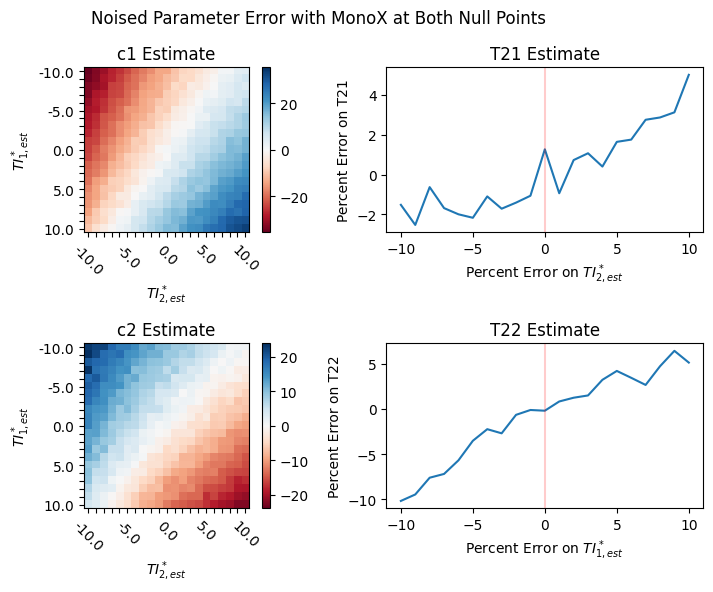

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(8,6), tight_layout=True)
fig.suptitle(f"Noised Parameter Error with MonoX at Both Null Points\nSNR = {SNR_fixed}")

delta_array = allParam_range_rel*100
param_metric = allParam_error_rel_SNR

labels = ['T11','T12','c1','c2','T21','T22']

ii = 2
row = 0
col = 0
#Construct a nice figure of each of the two 
imc = ax[row, col].imshow(param_metric[:,:,ii], cmap = 'RdBu', vmin = -1*np.max(np.abs(param_metric[:,:,ii])), vmax = np.max(np.abs(param_metric[:,:,ii])))
ax[row, col].set_xlabel(np_label_2)
ax[row, col].set_ylabel(np_label_1)
ax[row, col].set_xticks(np.arange(len(delta_array)))
ax[row, col].set_yticks(np.arange(len(delta_array)))
ax[row, col].set_xticklabels(delta_array)
ax[row, col].set_yticklabels(delta_array)
original_labels = [np.round(label,2) for label in delta_array]
labels_of_interest = [np.round(delta_array[i],2) for i in np.arange(0,delta_array.shape[0],5)]
new_labels = [label if label in labels_of_interest else "" for label in original_labels]
ax[row, col].set_xticklabels(new_labels, rotation=-45)
ax[row, col].set_yticklabels(new_labels)
ax[row, col].set_title(f"c1 Estimate")
plt.colorbar(imc, ax=ax[row, col], fraction=0.046, pad=0.04)

ii = 3
row = 1
col = 0
#Construct a nice figure of each of the two 
imc = ax[row, col].imshow(param_metric[:,:,ii], cmap = 'RdBu', vmin = -1*np.max(np.abs(param_metric[:,:,ii])), vmax = np.max(np.abs(param_metric[:,:,ii])))
ax[row, col].set_xlabel(np_label_2)
ax[row, col].set_ylabel(np_label_1)
ax[row, col].set_xticks(np.arange(len(delta_array)))
ax[row, col].set_yticks(np.arange(len(delta_array)))
ax[row, col].set_xticklabels(delta_array)
ax[row, col].set_yticklabels(delta_array)
original_labels = [np.round(label,2) for label in delta_array]
labels_of_interest = [np.round(delta_array[i],2) for i in np.arange(0,delta_array.shape[0],5)]
new_labels = [label if label in labels_of_interest else "" for label in original_labels]
ax[row, col].set_xticklabels(new_labels, rotation=-45)
ax[row, col].set_yticklabels(new_labels)
ax[row, col].set_title(f"c2 Estimate")
plt.colorbar(imc, ax=ax[row, col], fraction=0.046, pad=0.04)

ii = 2
param_metric = TI1star_error_rel_SNR
row = 0
col = 1
#Construct a nice figure of each of the two 
ax[row, col].plot(delta_array, param_metric[:,ii])
ax[row, col].axvline(x = 0, color='r', linestyle = '-', alpha=0.2)
ax[row, col].set_xlabel(f"Percent Error on {np_label_2}")
ax[row, col].set_ylabel(f"Percent Error on T21")
ax[row, col].set_title(f"T21 Estimate")

ii = 2
param_metric = TI2star_error_rel_SNR
row = 1
col = 1
#Construct a nice figure of each of the two 
ax[row, col].plot(delta_array, param_metric[:,ii])
ax[row, col].axvline(x = 0, color='r', linestyle = '-', alpha=0.2)
ax[row, col].set_xlabel(f"Percent Error on {np_label_1}")
ax[row, col].set_ylabel(f"Percent Error on T22")
ax[row, col].set_title(f"T22 Estimate")

plt.show()

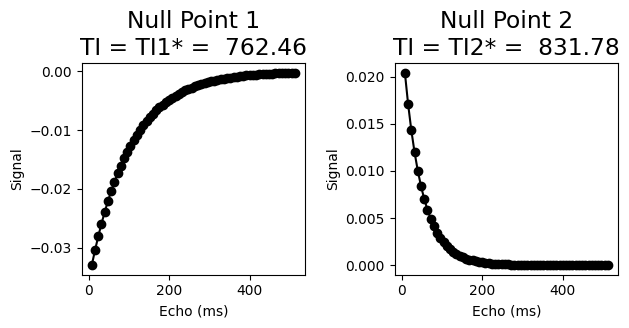

In [227]:
fig, ax = plt.subplots(1,2, figsize=(6.5,3.5), tight_layout=True)
plt.rc('font', size = 14)
ax[0].plot(TE_array, S_biX_6p(TE_array, TI1star, *true_params), marker = 'o', color = 'k')
ax[0].set_title(f'Null Point 1\nTI = TI1* = {TI1star: 0.2f}')
ax[0].set_xlabel('Echo (ms)')
ax[0].set_ylabel('Signal')
ax[1].plot(TE_array, S_biX_6p(TE_array, TI2star, *true_params), marker = 'o', color = 'k')
ax[1].set_title(f'Null Point 2\nTI = TI2* = {TI2star: 0.2f}')
ax[1].set_xlabel('Echo (ms)')
ax[1].set_ylabel('Signal')
plt.show()
plt.rc('font', size = 11)